# 1. Data Collection

## 1.1 Import all Necessary Packages

In [17]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from datetime import date, time, datetime, timedelta

## 1.2 Import the Raw Data

In [18]:
data = pd.read_csv("philadelphia_2019.csv")
weatherData = pd.read_csv("weather_hourly_philadelphia.csv")

## 1.3 Get an Overview over the Dataset

In [19]:
data.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
0,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park"
1,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park"
2,2019-01-01 00:52:00,2019-01-01 01:05:00,3166,3169,14623,Indego30,Frankford & Belgrade,2nd & Race
3,2019-01-01 00:55:00,2019-01-01 01:04:00,3058,3103,11706,Indego30,20th & Fairmount,"27th & Master, Athletic Recreation Center"
4,2019-01-01 01:05:00,2019-01-01 01:17:00,3182,3028,11039,Indego30,17th & Sansom,4th & Bainbridge


In [20]:
data.describe()

,start_station_id,end_station_id,bike_id
count,744260.000000,744260.000000,744260.000000
mean,3081.936112,3081.409467,9825.729611
std,58.702453,59.296591,5404.388722
min,3000.000000,3000.000000,1.000000
25%,3033.000000,3032.000000,3729.000000
50%,3062.000000,3062.000000,11744.000000
75%,3123.000000,3124.000000,14592.000000
max,3210.000000,3210.000000,20265.000000


In [21]:
# get all different user types

user_type_list = data['user_type'].unique()
user_type_list

array(['Indego30', 'Day Pass', 'Indego365', 'IndegoFlex', 'Walk-up', nan],
      dtype=object)

In [31]:
# Get total Fleet Size and Availability

fleet_size = len(data_clean["bike_id"].unique())

print("The bike fleet from Indego consists of {} bikes (for the observed time frame)".format(fleet_size))

The bike fleet from Indego consists of 1677 bikes (for the observed time frame)


# 2. Data Preparation

## 2.1 Formatting and Adding Attributes

In [22]:
# make timestamps out of 'start_time' and 'end_time'

data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

In [23]:
# add durations of each ride

data['duration'] = data['end_time'] - data['start_time']

In [24]:
# Maps time of day and day of week to our DF

def get_date (ts):
    return ts.date()

def get_weekday (ts):
    return ts.weekday()

def get_hour (ts):
    return ts.hour

def get_minute (ts):
    return ts.minute

In [25]:
# splits start/ end time further into date, weekday, hour and minute

data["start_date"] = data["start_time"].apply(lambda ts: get_date (ts))
data["start_weekday"]=data["start_time"].apply(lambda x: get_weekday (x))
data["start_hour"]=data["start_time"].apply(lambda x: get_hour (x))
data["start_minute"]=data["start_time"].apply(lambda x: get_minute (x))

data["end_date"] = data["end_time"].apply(lambda ts: get_date (ts))
data["end_weekday"]=data["end_time"].apply(lambda x: get_weekday (x))
data["end_hour"]=data["end_time"].apply(lambda x: get_hour (x))
data["end_minute"]=data["end_time"].apply(lambda x: get_minute (x))

In [27]:
# adds column with verbosed weekday into DF
weekday_dict = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
data["weekday_verbose_start"] = data["start_weekday"].apply(lambda x: weekday_dict[x])
data["weekday_verbose_end"] = data["end_weekday"].apply(lambda x: weekday_dict[x])

## 2.2 Dealing with Missing Values

In [32]:
# get number of missing values

data.isnull().sum()

start_time                0
end_time                  0
start_station_id          0
end_station_id            0
bike_id                   0
user_type                35
start_station_name        0
end_station_name          0
duration                  0
start_date                0
start_weekday             0
start_hour                0
start_minute              0
end_date                  0
end_weekday               0
end_hour                  0
end_minute                0
weekday_verbose_start     0
weekday_verbose_end       0
dtype: int64

because there are only 35 out of 744260 rows with missing values, we can simply drop these rows

In [33]:
# drop rows with missing values

data_clean_temp = data.dropna(axis=0, inplace=False)

## 2.3 Dealing with Outliers

Possible outliers are rides with a very high or low duration

In [34]:
data_clean_temp.duration.describe()

count                       744225
mean     0 days 00:24:44.368654640
std      0 days 02:03:47.463561723
min              -1 days +23:06:39
25%                0 days 00:07:00
50%                0 days 00:11:00
75%                0 days 00:19:00
max               21 days 13:24:08
Name: duration, dtype: object

we can drop rows with a duration ≤ 0 or a duration > 3 standard deviations because these are not representative

In [35]:
# get rows with duration <= 0

low_duration = data_clean_temp.duration[data_clean_temp.duration <= pd.Timedelta(0)]
low_duration.count()

42

In [36]:
# get rows with duration > 3 standard deviations

high_duration = data_clean_temp.duration[(data_clean_temp.duration > 3*data_clean_temp.duration.std())]
high_duration.count()

4322

In [37]:
# drop these rows

data_clean_temp2 = data_clean_temp.drop(high_duration.index)
data_clean = data_clean_temp2.drop(low_duration.index)

# 3. Descriptive Analytics

## 3.1 Temporal Demand Patterns and Seasonality

### 3.1.1 Average Usage per Weekday

In [41]:
# Availability by day of week 

bike_trips_weekday = data_clean.groupby(["start_date", "weekday_verbose_start"]).size().unstack(fill_value=0)
mean = ['mean']
bike_trips_mean_per_weekday = pd.DataFrame(bike_trips_weekday[["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]].mean(), columns=mean)
bike_trips_mean_per_weekday

,mean
weekday_verbose_start,
Mon,294.350685
Tue,321.912329
Wed,311.257534
Thu,302.367123
Fri,307.536986
Sat,264.824658
Sun,224.767123


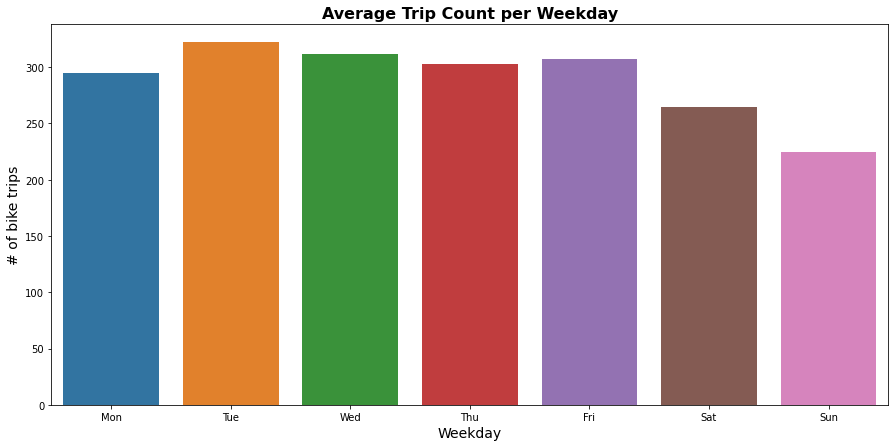

In [42]:
fig,ax = plt.subplots(figsize=(15,7)) 

sns.barplot(x=bike_trips_mean_per_weekday.index, y='mean', data=bike_trips_mean_per_weekday, ax=ax)
ax.set_title('Average Trip Count per Weekday', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_ylabel("# of bike trips", fontsize=14)
ax.set_xlabel("Weekday", fontsize=14)

plt.show()

### 3.1.2 Trip Duration per Weekday

[Text(0.5, 0, 'Weekdays'), Text(0, 0.5, 'Trip Duration in Seconds')]

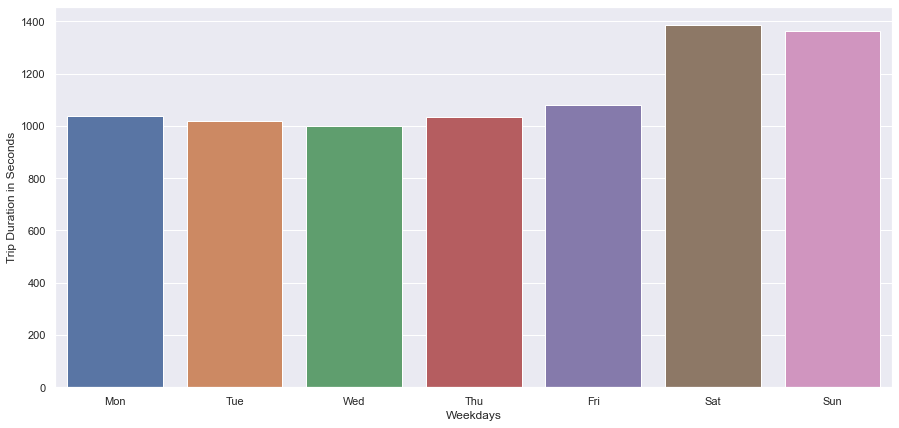

In [46]:
# get average trip duration per weekday

avg_duration_mon = data_clean.duration[(data_clean.start_weekday == 0)].sum() / data_clean.duration[(data_clean.start_weekday == 0)].count()
avg_duration_tue = data_clean.duration[(data_clean.start_weekday == 1)].sum() / data_clean.duration[(data_clean.start_weekday == 1)].count()
avg_duration_wed = data_clean.duration[(data_clean.start_weekday == 2)].sum() / data_clean.duration[(data_clean.start_weekday == 2)].count()
avg_duration_thu = data_clean.duration[(data_clean.start_weekday == 3)].sum() / data_clean.duration[(data_clean.start_weekday == 3)].count()
avg_duration_fri = data_clean.duration[(data_clean.start_weekday == 4)].sum() / data_clean.duration[(data_clean.start_weekday == 4)].count()
avg_duration_sat = data_clean.duration[(data_clean.start_weekday == 5)].sum() / data_clean.duration[(data_clean.start_weekday == 5)].count()
avg_duration_sun = data_clean.duration[(data_clean.start_weekday == 6)].sum() / data_clean.duration[(data_clean.start_weekday == 6)].count()


# make a Series with durations in seconds for plotting

avg_durations = pd.Series([avg_duration_mon, avg_duration_tue, avg_duration_wed, avg_duration_thu, avg_duration_fri, avg_duration_sat, avg_duration_sun], index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']).astype('timedelta64[s]')

# plot
fig,ax = plt.subplots(figsize=(15,7))
sns.set_theme(style="darkgrid")
plot = sns.barplot(x=avg_durations.index, y=avg_durations)
plot.set(xlabel='Weekdays', ylabel='Trip Duration in Seconds')

here we can see, that the average trip duration is higher on weekends

### 3.1.3 Seasonal Usage

### 3.1.4 Seasonal Patterns of Usage on Weekdays

### 3.1.5 Temperature and Usage Correlation

## 3.2 Geographical Demand Patterns

## 3.3 Key Performance Indicators

# 4. Predictive Analytics